In [12]:
import pandas as pd

data = pd.read_csv('/home/titanium/Desktop/skrv/sample_data.csv')

In [2]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Haversine function vectorized
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0 #Radius of Earth
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [13]:
df = pd.read_csv('sample_data.csv')

# Sorting timestamps for efficiency
df = df.sort_values('timestamp').reset_index(drop=True)

# Vessel proximity cutoff threshold
proximity_threshold = 0.1  # in kilometers

proximity_events = []

for timestamp in df['timestamp'].unique():
    # Filtering vessels for current timestamp
    current_data = df[df['timestamp'] == timestamp].reset_index(drop=True)

    # Vectorized pairwise distance calculation
    latitudes = current_data['lat'].values
    longitudes = current_data['lon'].values
    mmsis = current_data['mmsi'].values
    
    # Expanding the latitude and longitude arrays for vectorized operations
    lat_matrix1 = np.repeat(latitudes, len(latitudes))
    lon_matrix1 = np.repeat(longitudes, len(longitudes))
    lat_matrix2 = np.tile(latitudes, len(latitudes))
    lon_matrix2 = np.tile(longitudes, len(longitudes))
    
    distances = haversine_vectorized(lat_matrix1, lon_matrix1, lat_matrix2, lon_matrix2)
    
    # Distance square matrix
    distance_matrix = distances.reshape(len(latitudes), len(latitudes))
    
    # Setting diagonal to a large value to avoid self comparison
    np.fill_diagonal(distance_matrix, np.inf)
    
    # Proximity events
    close_vessels = np.where(distance_matrix <= proximity_threshold)
    
    for i, j in zip(close_vessels[0], close_vessels[1]):
        proximity_events.append({
            'mmsi': mmsis[i],
            'vessel_proximity': mmsis[j],
            'timestamp': timestamp
        })

proximity_df = pd.DataFrame(proximity_events)

print(proximity_df)

          mmsi  vessel_proximity               timestamp
0    565761000         352002300  2023-03-12 14:30:00+00
1    352002300         565761000  2023-03-12 14:30:00+00
2    565761000         352002300  2023-03-12 15:30:00+00
3    352002300         565761000  2023-03-12 15:30:00+00
4    352002300         565761000  2023-03-12 16:30:00+00
..         ...               ...                     ...
353  563014650         563014650  2023-03-24 04:58:36+00
354  563078430         563078430  2023-03-24 04:58:52+00
355  563078430         563078430  2023-03-24 04:58:52+00
356  518998309         518998309  2023-03-24 04:59:46+00
357  518998309         518998309  2023-03-24 04:59:46+00

[358 rows x 3 columns]


In [14]:
# Saving output to a csv file
proximity_df.to_csv('/home/titanium/Desktop/skrv/vessel_proximity_events.csv', index=False)

In [15]:
sample_data = pd.read_csv('/home/titanium/Desktop/skrv/sample_data.csv')

In [16]:
# Merging the proximity data with the original sample data to include latitude and longitude
proximity_df = pd.merge(proximity_df, sample_data[['mmsi', 'lat', 'lon']], on='mmsi', how='left')

print(proximity_df.head())


        mmsi  vessel_proximity               timestamp       lat        lon
0  565761000         352002300  2023-03-12 14:30:00+00  1.268780  103.75827
1  565761000         352002300  2023-03-12 14:30:00+00  1.164080  103.76326
2  565761000         352002300  2023-03-12 14:30:00+00  1.228610  103.71950
3  565761000         352002300  2023-03-12 14:30:00+00  1.233600  103.71625
4  565761000         352002300  2023-03-12 14:30:00+00  1.191464  103.73025


In [17]:
import geopandas as gpd

# Creating a GeoDataFrame
gdf = gpd.GeoDataFrame(
    proximity_df, 
    geometry=gpd.points_from_xy(proximity_df.lon, proximity_df.lat),
    crs="EPSG:4326"  # WGS84 coordinate system
)

print(gdf.head())


        mmsi  vessel_proximity               timestamp       lat        lon  \
0  565761000         352002300  2023-03-12 14:30:00+00  1.268780  103.75827   
1  565761000         352002300  2023-03-12 14:30:00+00  1.164080  103.76326   
2  565761000         352002300  2023-03-12 14:30:00+00  1.228610  103.71950   
3  565761000         352002300  2023-03-12 14:30:00+00  1.233600  103.71625   
4  565761000         352002300  2023-03-12 14:30:00+00  1.191464  103.73025   

                    geometry  
0  POINT (103.75827 1.26878)  
1  POINT (103.76326 1.16408)  
2   POINT (103.7195 1.22861)  
3   POINT (103.71625 1.2336)  
4  POINT (103.73025 1.19146)  


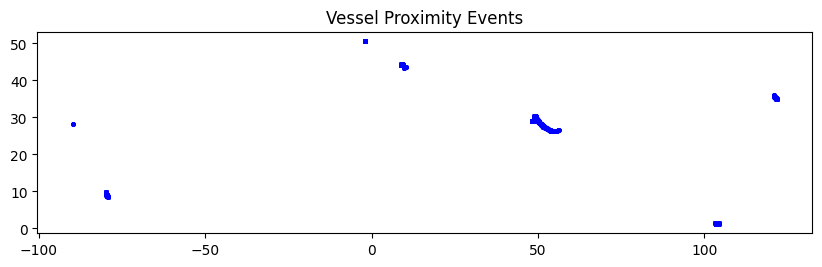

In [18]:
import matplotlib.pyplot as plt

# Plotting the proximity events on map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='blue', markersize=5)

ax.set_title('Vessel Proximity Events')
plt.show()


In [19]:
import plotly.express as px
import geopandas as gpd

gdf['lat'] = gdf.geometry.y
gdf['lon'] = gdf.geometry.x

# Plotting using Plotly
fig = px.scatter_mapbox(
    gdf, 
    lat="lat", 
    lon="lon", 
    color="mmsi", 
    size_max=15, 
    zoom=10,
    title="Vessel Proximity Events",
    mapbox_style="carto-positron"
)

# Saving the plot to a HTML file for easy viewing
fig.write_html("vessel_proximity_events.html")

